In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt


import os
from models import TransformerModel, ChebyshevKernelLeastSquaresModel
from tasks import get_task_sampler, ClampedChebyshev, ChebyshevKernelLinearRegression
from samplers import get_data_sampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import *
from samplers import *
import yaml
from types import SimpleNamespace
from tqdm import tqdm

from interpretability import *
from graphing import *

torch.set_num_threads(4)  # Set this to the number of threads you want
torch.set_num_interop_threads(4)
GPU = 1
device = torch.device(f"cuda:{GPU}")


/home/dylandavis/.conda/envs/in-context-learning/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_model_path =  "../models/finetune_chebyshev_standard_clamped_loss/first_finetune_run"#../models/eval_ckpts/c3b57089-5466-4a2d-a9a7-d82eff45732a/"#'/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
config_path = os.path.join(base_model_path, "config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

def dict_to_namespace(d):
    if isinstance(d, dict):
        return SimpleNamespace(**{k: dict_to_namespace(v) for k, v in d.items()})
    return d
config = dict_to_namespace(config)

base_model = build_model(config.model)
base_model.to(device)

state_path = os.path.join(base_model_path, "model_250000.pt")
state = torch.load(state_path, map_location=device)
base_model.load_state_dict(state)

#finetuned_model_path = "../models/finetuned123"
#finetuned_model = get_model(finetuned_model_path, n_embd=128, n_layer=6, n_head=4)

FileNotFoundError: [Errno 2] No such file or directory: '../models/finetune_chebyshev_standard_clamped_loss/first_finetune_run/model_250000.pt'

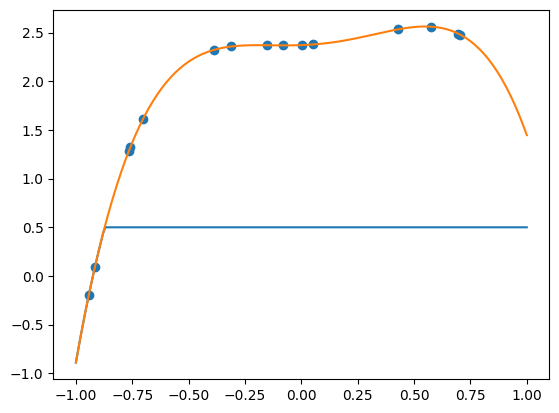

In [ ]:
sampler = UniformSampler(n_dims=1)

clamped_task = ClampedChebyshev(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
orig_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)


chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)

num_xs_to_pred = 200

#xs_context = sampler.sample_xs(255, 1)
xs_context = sampler.sample_xs(15, 1)
#xs_to_pred = sampler.sample_xs(num_xs_to_pred, 1)
xs_to_pred = torch.linspace(-1, 1, num_xs_to_pred).view(1,200,1)



#ys_clamped_context = clamped_task.evaluate(xs_context, noise=False, separate_noise=False)
#ys_clamped_to_pred = clamped_task.evaluate(xs_to_pred, noise=False, separate_noise=False)
ys_unclamped_context = orig_task.evaluate(xs_context, noise=False, separate_noise=False)
ys_unclamped_to_pred = orig_task.evaluate(xs_to_pred, noise=False, separate_noise=False)

ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

xs_gt, ys_gt = torch.concat((xs_context.squeeze(), xs_to_pred.squeeze())), torch.concat((ys_clamped_context.squeeze(), ys_clamped_to_pred.squeeze()))

# # plot the grount truth clamped polynomial
plt.plot(xs_to_pred.squeeze(), ys_clamped_to_pred.squeeze())
plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze())
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze())

Text(0.5, 1.0, 'Base Model: Degree 4 Clamping From Context')

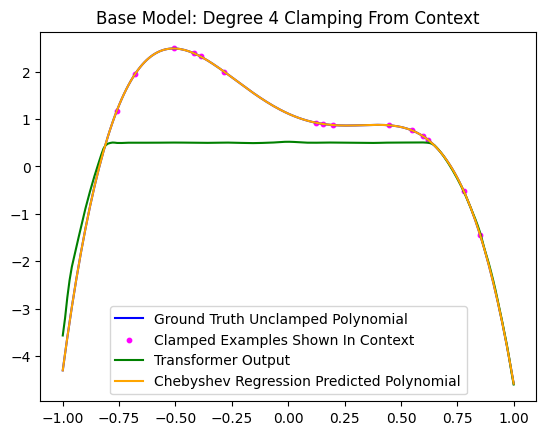

In [ ]:
predicted_ys_on_context = []
chebyshev_predicted = []
xs_to_pred = xs_to_pred.squeeze()
xs_context = xs_context.squeeze()
ys_unclamped_context = ys_unclamped_context.squeeze()
ys_unclamped_to_pred = ys_unclamped_to_pred.squeeze()

ys_clamped_context = ys_clamped_context.squeeze()
ys_clamped_to_pred = ys_clamped_to_pred.squeeze()

for i in range(0, num_xs_to_pred):
    xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]])))
    ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]])))

    xs = xs.unsqueeze(0)    
    xs = xs.unsqueeze(-1)  

    ys = ys.unsqueeze(0)

    xs = xs.to(device)
    ys = ys.to(device)

    pred = base_model(xs, ys).detach().cpu()
    predicted_ys_on_context.append(pred.squeeze()[-1])

    chebyshev_pred = chebyshev_model(xs,ys)
    chebyshev_predicted.append(chebyshev_pred.squeeze()[-1])


plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze(), label="Ground Truth Unclamped Polynomial", color="blue")
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze(), label="Clamped Examples Shown In Context", color="fuchsia",marker='o', s=10)
plt.plot(xs_to_pred.squeeze(), predicted_ys_on_context, label="Transformer Output", color="green")
plt.plot(xs_to_pred.squeeze(), chebyshev_predicted, label="Chebyshev Regression Predicted Polynomial", color="orange")

plt.legend()
plt.title("Base Model: Degree 4 Clamping From Context")

In [3]:
num_tasks = 1000
context_size = 25

num_predictions = 5

sampler = UniformSampler(n_dims=1)

recorder_unclamped = ActivationRecorder()
recorder_clamped = ActivationRecorder()

hooks_clamped = register_residual_hooks(base_model, recorder_clamped)
# Collect Refusal activations
for _ in tqdm(range(num_tasks)):

    chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

    xs_context = sampler.sample_xs(context_size, 1)
    xs_to_pred = sampler.sample_xs(num_predictions, 1)

    ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
    ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

    ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
    ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

    xs_context = xs_context.squeeze()
    xs_to_pred = xs_to_pred.squeeze()

    for i in range(0, num_predictions):
        
        # only look at examples that are being reused (leave a little room for numerical uncertainty)
        if ys_unclamped_to_pred[i] > 0.6:
            continue

        xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]]))).view(1,26,1).to(device)
        ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]]))).view(1,26).to(device)

        _ = base_model(xs, ys).detach().cpu()

clear_hooks(hooks_clamped)        

hooks_unclamped = register_residual_hooks(base_model, recorder_unclamped)
# Collect Refusal activations
for _ in tqdm(range(num_tasks)):

    chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

    xs_context = sampler.sample_xs(context_size, 1)
    xs_to_pred = sampler.sample_xs(num_predictions, 1)

    ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
    ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

    ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
    ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

    xs_context = xs_context.squeeze()
    xs_to_pred = xs_to_pred.squeeze()

    for i in range(0, num_predictions):
        
        # only look at examples that are not being reused (leave a little room for numerical uncertainty)
        if ys_unclamped_to_pred[i] < 0.4:
            continue

        xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]]))).view(1,26,1).to(device)
        ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]]))).view(1,26).to(device)

        _ = base_model(xs, ys).detach().cpu()

clear_hooks(hooks_unclamped)        
    

100%|██████████| 1000/1000 [00:08<00:00, 118.05it/s]


In [4]:
mean_clamped = recorder_clamped.get_mean_activations()
mean_unclamped = recorder_unclamped.get_mean_activations()

# Compute difference-in-means per layer
diff_vectors = {
    layer: mean_unclamped[layer] - mean_clamped[layer]
    for layer in mean_clamped
}

refusal_vector = {
    layer: diff.mean(dim=(0, 1))  # mean over batch & sequence
    for layer, diff in diff_vectors.items()
}


In [7]:
diff_vectors[0].shape

torch.Size([1, 52, 128])

In [13]:
diff_vectors[0].squeeze(0)[-1]

tensor([ 1.2587e-01,  5.7209e-01, -2.0499e-01,  2.1247e-02,  1.2468e-01,
        -1.8340e-01,  2.0517e-01,  2.9664e+00,  6.1891e-01, -1.7163e+00,
        -3.1880e-02,  2.8915e-01,  2.5310e-01, -7.6082e-02,  2.0897e-01,
        -4.1497e-01,  3.6655e-01, -3.6266e-02, -1.0952e-01, -5.1710e-01,
         8.1363e-02, -9.5898e-01, -6.5642e-02, -2.0493e-02,  1.0635e-01,
         2.3553e-01, -2.0974e-01, -9.1109e-02,  7.2144e-02, -1.0440e-03,
         2.7317e-01,  8.6069e-02,  1.6441e-01,  4.4195e-01, -9.2054e-02,
        -1.6187e-01,  6.1889e-02,  1.0078e-01,  1.6784e-02,  2.8584e-01,
         1.1747e-01, -8.6414e-01,  3.8868e-01,  1.1909e+00, -2.3468e-01,
         4.4919e-02, -6.4489e-02,  1.8370e-01, -3.1147e-01,  1.7737e-01,
         3.3975e-01, -3.9579e-02,  1.8372e-01, -1.1135e+00, -6.2412e-02,
         1.6036e-01, -4.5735e-01, -2.7196e-02, -5.5302e-03, -2.5475e-01,
        -2.3438e-01,  1.1848e+00,  1.4966e-01, -3.1425e-01,  6.6128e-02,
         1.0762e-01, -3.0562e-02,  1.7786e-01,  2.8

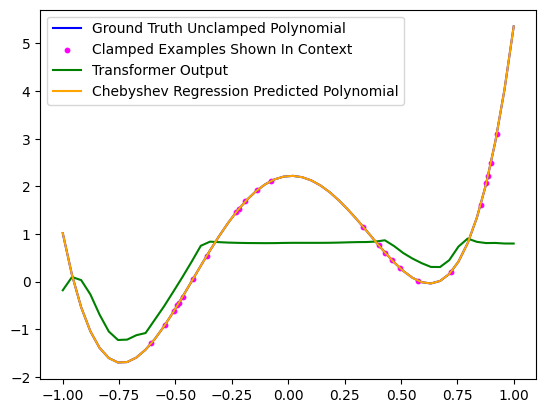

In [15]:
context_size = 25
num_predictions = 50

target_layer = 1
refuse_vector = diff_vectors[target_layer].squeeze(0)[-2]
#refuse_vector = refusal_vector[target_layer]


chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)
sampler = UniformSampler(n_dims=1)

predicted_ys_on_context = []
chebyshev_predicted = []

xs_context = sampler.sample_xs(context_size, 1)
xs_to_pred = torch.linspace(-1, 1, num_predictions).view(1,num_predictions,1)

ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

xs_context = xs_context.squeeze()
xs_to_pred = xs_to_pred.squeeze()

handles = make_global_ablation_hooks(base_model, refuse_vector)
for i in range(0, num_predictions):
    xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]])))
    ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]])))

    xs = xs.unsqueeze(0)    
    xs = xs.unsqueeze(-1)  

    ys = ys.unsqueeze(0)

    xs = xs.to(device)
    ys = ys.to(device)

    pred = base_model(xs, ys).detach().cpu()
    predicted_ys_on_context.append(pred.squeeze()[-1])

    chebyshev_pred = chebyshev_model(xs,ys)
    chebyshev_predicted.append(chebyshev_pred.squeeze()[-1])

clear_hooks(handles)

plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze(), label="Ground Truth Unclamped Polynomial", color="blue")
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze(), label="Clamped Examples Shown In Context", color="fuchsia",marker='o', s=10)
plt.plot(xs_to_pred.squeeze(), predicted_ys_on_context, label="Transformer Output", color="green")
plt.plot(xs_to_pred.squeeze(), chebyshev_predicted, label="Chebyshev Regression Predicted Polynomial", color="orange")

plt.legend()

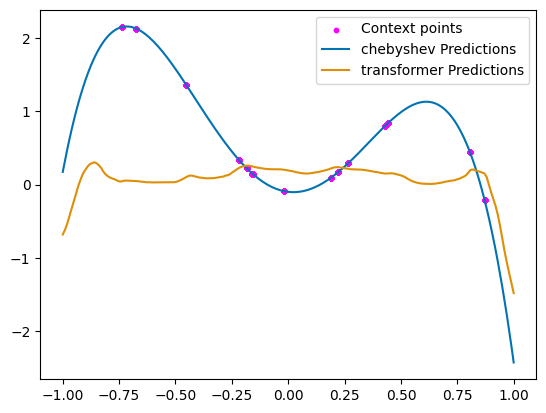

In [ ]:
chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)
sampler = UniformSampler(n_dims=1)

activations = ActivationRecorder()

unablated = ActivationRecorder()

target_layer = 2
refuse_vector = diff_vectors[target_layer].squeeze(0)[-2]

models= {
    "chebyshev": chebyshev_model,
    "transformer": base_model
}


xs_context = sampler.sample_xs(15, 1).to(device)
xs_to_pred = torch.linspace(-1, 1, 200).view(1,200,1).to(device)
ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).to(device)
ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).to(device)


pre_ablation = register_residual_hooks(base_model, unablated)

handles = make_global_ablation_hooks(base_model, refuse_vector)

activation_hook = register_residual_hooks(base_model, activations)


plot_polynomial(xs_context, ys_unclamped_context, xs_to_pred, ys_unclamped_to_pred, models)

clear_hooks(pre_ablation)
clear_hooks(handles)
clear_hooks(activation_hook)


In [7]:
from eval import get_model_from_run

m, _ = get_model_from_run("../models/chebyshev_base_standard/ecc58e0f-265b-44fa-a78e-5e57f408c9d6", step=100000)

In [23]:
task_dir = "../models/chebyshev_base_standard/ecc58e0f-265b-44fa-a78e-5e57f408c9d6/checkpoints"

for run_id in os.listdir(task_dir):
    print(run_id)

model_800000.pt
model_100000.pt
model_400000.pt
model_600000.pt
state.pt
model_200000.pt
model_500000.pt
model_300000.pt
model_900000.pt
model_1000000.pt
model_700000.pt


In [78]:
predicted_ys = torch.tensor([])
actual_ys = torch.tensor([])

In [85]:
GPU = 1
device = torch.device(f"cuda:{GPU}")

samples_per_task = 10
context_size = 40



task_class = ChebyshevKernelLinearRegression
model=base_model

task = task_class(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

xs_context = sampler.sample_xs(context_size, 1)
xs_to_predict = sampler.sample_xs(samples_per_task, 1)

ys_context = task.evaluate(xs_context, noise=False, separate_noise=False)
ys_to_predict = task.evaluate(xs_to_predict, noise=False, separate_noise=False)

context_x = xs_context.repeat(xs_to_predict.shape[1], 1, 1)
prompt_x = xs_to_predict.permute(1, 0, 2) # (num predictions, 1, 1)
input_x = torch.cat([context_x, prompt_x], dim=1) #add our x prediction points to the end of our fixed cntext

#dont have a dimension size for our output arrays
context_y = ys_context.repeat(ys_to_predict.shape[1], 1)  # (number of predictions, context size)
predict_y = ys_to_predict.view(-1, 1)  # (number of predictions, 1)
input_y = torch.cat([context_y, predict_y], dim=1)

input_x = input_x.to(device)
input_y = input_y.to(device)
model.to(device)

predictions = model(input_x, input_y).detach().cpu().squeeze()

predicted_ys= torch.cat([predicted_ys, predictions[:,-1]])
actual_ys= torch.cat( [actual_ys, ys_to_predict.cpu().squeeze()])

In [91]:
actual_ys.shape[0]

40

In [83]:
predicted_ys

tensor([-1.6706, -2.3190, -2.3321, -1.9588, -1.2307, -1.6621, -0.5810, -2.1580,
        -1.7443, -1.3917, -0.7473, -1.1631, -0.3540, -3.2254, -0.2335, -0.1575,
        -1.7265, -1.5036, -1.7734, -1.3750])

In [93]:
(actual_ys - predicted_ys).square().mean().item()

0.023915132507681847

In [68]:
predicted_ys.append(actual_ys)

In [53]:
sampler.sample_xs(10,1).shape

torch.Size([1, 10, 1])

In [ ]:
activations.activations[1][0][0][0] @ refuse_vector

tensor(6.2585e-07)

In [ ]:
layer = 1

total = 0
max = 0
max_a = 0
for b in tqdm(range(200)):
    for p in range(32):
        residual = activations.activations[layer][0][b][p] @ refuse_vector
        residual = abs(residual)
        if residual > max:
            max = residual


        residual_a = unablated.activations[layer][0][b][p] @ refuse_vector
        residual_a = abs(residual_a)
        if residual_a > max_a:
            max_a = residual_a

        total += residual

average = total / (200*32)
print(average)
print(max)
print(max_a)

100%|██████████| 200/200 [00:00<00:00, 1972.85it/s]

tensor(8.5048e-07)
tensor(4.2915e-06)
tensor(10.1126)


1

In [ ]:
activations.activations[1][0].shape

torch.Size([200, 32, 128])

In [ ]:
base_model._backbone.h

ModuleList(
  (0): GPT2Block(
    (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (resid_dropout): Dropout(p=0.0, inplace=False)
    )
    (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (1): GPT2Block(
    (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (resid_dropout): Dropout(p=0.0, inplace=False)
    )
    (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.0, inplace=False)
    )


In [ ]:
handles = make_global_ablation_hooks(base_model, refuse_vector)
base_model._backbone.h

ModuleList(
  (0): GPT2Block(
    (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (resid_dropout): Dropout(p=0.0, inplace=False)
    )
    (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (1): GPT2Block(
    (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (resid_dropout): Dropout(p=0.0, inplace=False)
    )
    (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.0, inplace=False)
    )


In [4]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

/tmp/ipykernel_2076882/2566099178.py:3: RuntimeWarning: divide by zero encountered in true_divide
  y = 1/x


<AxesSubplot:title={'center':'Line Plot with Shaded Error Bars'}, xlabel='X-axis', ylabel='Y-axis'>

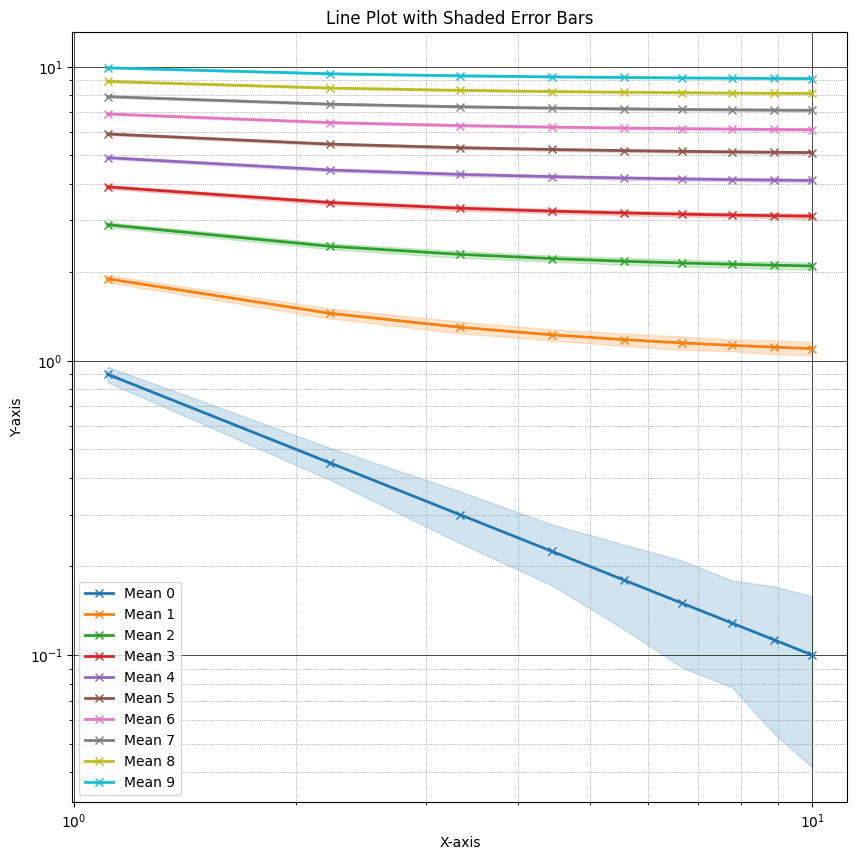

In [5]:
# Sample data
x = np.linspace(0, 10, 10)
y = 1/x
error =  0.05 + 0.01 * np.abs(np.cos(x))  # Example variable error

colors = plt.cm.tab10(np.linspace(0, 1, 10))
i=7
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
for i in range(10):
    # Plot the main line
    ax.plot(x, y+i, marker = 'x', label=f'Mean {i}', linewidth= 2, color=colors[i])
    #plt.scatter(x[::10],y[::10])

    # Plot the shaded error region
    ax.fill_between(x, y - error + i, y + error + i, color=colors[i], alpha=0.2)



# Labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Plot with Shaded Error Bars')

ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax.minorticks_on()
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid(True)
ax

<AxesSubplot:xlabel='training steps', ylabel='squared error'>

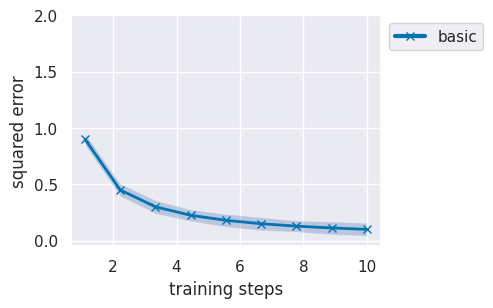

In [ ]:
from plot_utils import basic_plot, plot_checkpoints

metrics = {"basic":{
    "mean" : y,
    "checkpoints": x,
    "low":y - error,
    "high": y + error
},
#"other":{
#    "mean" : x,
#    "low":x - error,
#    "high": x + error
#}
}



#_, ax = basic_plot(metrics, ylim=2)
_, ax = plot_checkpoints(metrics)
#fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

#ax.plot(y, "-")
ax

<AxesSubplot:>

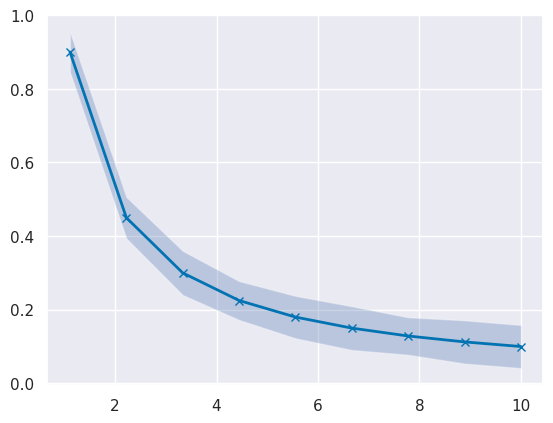

In [5]:
fig, ax = plt.subplots(1, 1)
color = 0
ylim = 2
    
for name, vs in metrics.items():
    ax.plot(vs["checkpoints"], vs["mean"], marker = "x", label=name, color=palette[color % 10], lw=2)
    low = vs["low"]
    high = vs["high"]
    ax.fill_between(vs["checkpoints"], low, high, alpha=0.3)
    color += 1


'''
ax.set_xlabel("training steps")
ax.set_ylabel("squared error")
    #ax.set_xlim(-1, len(low) + 0.1)
ax.set_ylim(-0.05, ylim)

legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.set_size_inches(4, 3)
for line in legend.get_lines():
    line.set_linewidth(3)
'''
ax

#fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

#ax.plot(x,y, marker="x")
#ax.fill_between(x, y-error, y+error, alpha=0.3)
#ax

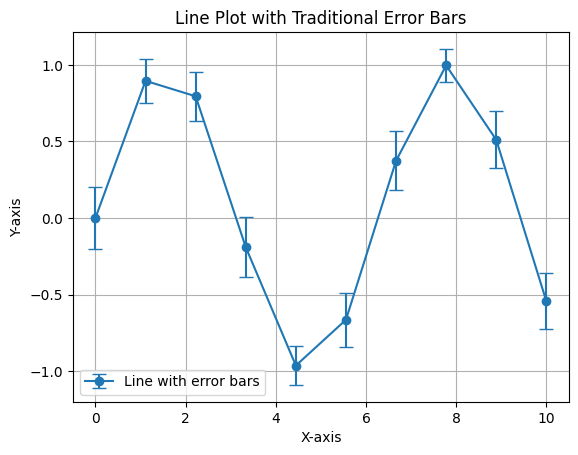

In [34]:
x = np.linspace(0, 10, 10)
y = np.sin(x)
y_err = 0.1 + 0.1 * np.abs(np.cos(x))  # Example error

plt.errorbar(x, y, yerr=y_err, fmt='-o', capsize=5, label='Line with error bars')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot with Traditional Error Bars')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
x[::10]

array([0.        , 1.01010101, 2.02020202, 3.03030303, 4.04040404,
       5.05050505, 6.06060606, 7.07070707, 8.08080808, 9.09090909])

In [17]:
chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)
sampler = UniformSampler(n_dims=1)

xs_context = sampler.sample_xs(10, 1)
xs_to_pred = torch.linspace(-1, 1, 20).view(1,20,1)

ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False)
ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False)

In [18]:
xs_context.shape

torch.Size([1, 10, 1])

In [19]:
ys_unclamped_to_pred.shape

torch.Size([1, 20])

In [20]:
# Step 1: Repeat a to match the number of entries in b
context = xs_context.repeat(xs_to_pred.shape[1], 1, 1)  # (20, 10, 1)

# Step 2: Reshape b so each of its values becomes a row (20, 1, 1)
prompt = xs_to_pred.permute(1, 0, 2)  # (20, 1, 1)

# Step 3: Concatenate along dimension 1 (the second dimension)
input = torch.cat([context, prompt], dim=1)

#print(input.shape)
#print(input)

In [21]:
# Step 1: Repeat a to match b's length
y_context = ys_unclamped_context.repeat(ys_unclamped_to_pred.shape[1], 1)  # (20, 10)

# Step 2: Reshape b to (20, 1) so it can be concatenated
y_predict = ys_unclamped_to_pred.view(-1, 1)  # (20, 1)

# Step 3: Concatenate along dimension 1
y_input = torch.cat([y_context, y_predict], dim=1)  # (20, 11)

print(y_input.shape)  # Should print: torch.Size([20, 11])

torch.Size([20, 11])


In [22]:
input = input.to(device)
y_input = y_input.to(device)
test = base_model(input,y_input)

In [24]:
m.to(device)
m(input,y_input)

tensor([[-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -1.3543],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -2.0433],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -2.0454],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -1.6449],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -1.2259],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419, -0.6316],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419,  0.0473],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0.0951, -0.3418,  0.4876,
         -0.1046, -1.1419,  0.4934],
        [-0.0396, -0.0523, -0.6210, -1.6300,  0.1634, -0

In [33]:
test[:,-1]

tensor([-0.8068, -1.5094, -0.9754, -1.5541, -2.5825, -1.7786, -3.6719, -4.9354,
        -4.4430, -3.2100, -2.0718, -2.7021, -2.1842, -1.1075, -0.6717, -0.9196,
        -1.8043, -2.6353, -1.6474, -1.1801], device='cuda:3',
       grad_fn=<SelectBackward0>)

In [10]:
x = torch.asarray([1,0.5]).view(1,2,1).to(device).squeeze()
y = torch.asarray([1,2]).view(1,2,1).to(device)

In [11]:
torch.linspace(-1, 1, 5)

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])

In [12]:
base_model(x,y).detach().cpu()

ValueError: not enough values to unpack (expected 3, got 1)

In [16]:
x.shape

torch.Size([2])